@inproceedings{souza2020bertimbau, author = {F{'a}bio Souza and Rodrigo Nogueira and Roberto Lotufo}, title = {{BERT}imbau: pretrained {BERT} models for {B}razilian {P}ortuguese}, booktitle = {9th Brazilian Conference on Intelligent Systems, {BRACIS}, Rio Grande do Sul, Brazil, October 20-23 (to appear)}, year = {2020} }

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip install nbstripout
!nbstripout /content/drive/MyDrive/2025/tcc-final/fine_tuning_Bertimbau_version2_24_07.ipynb

Could not strip '/content/drive/MyDrive/2025/tcc-final/fine_tuning_Bertimbau_version2_24_07.ipynb': file not found


# **1. Instalação e Configuração das Bibliotecas**

Nesta seção, preparamos o ambiente instalando todas as bibliotecas necessárias. Utilizamos o ***wordcloud*** para gerar a nuvem de palavras visualmente atraente, e a ***pandas*** para ler e manipular nosso conjunto de dados

In [9]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re
import string
import unicodedata
import pandas as pd

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# **2. Carregamento do Conjunto de Dados**

Aqui, carregamos nosso arquivo de denúncias processadas, ***denuncias_balanceadas.xlsx***. A biblioteca ***pandas*** nos ajuda a ler o arquivo em um formato de tabela, o que facilita a inspeção e o processamento dos dados textuais contidos na coluna 'texto'

Aqui além de carregar os dataset, também é feita amostras das primeiras linhas do dataset e suas classes

In [10]:
# Carregar dataset já processado
file_path = '/content/drive/MyDrive/2025/tcc-final/denuncias_balanceadas.xlsx'
df = pd.read_excel(file_path)

print(f"Dataset carregado. Total de registros: {len(df)}")
print("Primeiras 5 linhas do dataset:")
print(df.head())
print("\nInformações do dataset:")
print(df.info())

Dataset carregado. Total de registros: 169
Primeiras 5 linhas do dataset:
                                               texto             classe
0  Segundo informações da [VÍTIMA], na sexta, a m...  invasao_domicilio
1  Policiais arrombaram a casa, quebraram sapatei...  invasao_domicilio
2  [VÍTIMA] relata que sua vizinha [VÍTIMA] teve ...  invasao_domicilio
3  [VÍTIMA] relata que abriram o portão de sua ca...  invasao_domicilio
4  [VÍTIMA] teve a casa invadida por policiais do...  invasao_domicilio

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   169 non-null    object
 1   classe  169 non-null    object
dtypes: object(2)
memory usage: 2.8+ KB
None


# **3. Pré-processamento dos Textos**

Para gerar uma nuvem de palavras significativa, é importante 'limpar' o texto. Removemos palavras comuns (conhecidas como 'stopwords', como 'de', 'a', 'o') e números, que não agregam muito significado para a nossa análise. Além disso, convertemos todo o texto para minúsculas e removemos a pontuação, garantindo que palavras como 'Casa' e 'casa' sejam tratadas da mesma forma.

In [11]:
# Função para normalizar texto (remover acentos e converter para minúsculas)
def normalize_text(text):
    if pd.isna(text):
        return ""
    # Converter para minúsculas e remover acentos
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    return text

# Filtrar stopwords em português (já normalizadas)
stop_words = set(nltk.corpus.stopwords.words('portuguese'))
# Normalizar as stopwords do NLTK
stop_words = set([normalize_text(word) for word in stop_words])

# Adicionar stopwords específicas do domínio jurídico (já normalizadas)
stopwords_juridicas = [
    'artigo', 'lei', 'numero', 'n', 'processo', 'protocolo', 'requerente',
    'requerido', 'vitima', 'autoria', 'delito', 'informacoes', 'segundo',
    'mesmo', 'mesma', 'devido', 'fora', 'dia', 'meses', 'anos', 'horas',
    'minutos', 'momento', 'pais', 'nome', 'ate', 'apos',
    'email', 'cpf', 'rg', 'documento', 'data', 'hora'
]
stop_words.update(stopwords_juridicas)

def preprocess_text(text):
    # Se o texto for NaN, retorna string vazia
    if pd.isna(text):
        return ""

    # Converter para minúsculas e remover acentos
    text = normalize_text(text)

    # Remover pontuação e números
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\d+', ' ', text)

    # Remover colchetes e conteúdo entre colchetes (como [VITIMA])
    text = re.sub(r'\[.*?\]', ' ', text)

    # Remover palavras com menos de 3 caracteres
    text = re.sub(r'\b\w{1,2}\b', ' ', text)

    # Remover espaços extras
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def plot_wordcloud(texto, titulo):
    # Pré-processar o texto
    texto_limpo = preprocess_text(texto)

    # Tokenizar o texto para filtrar stopwords manualmente
    tokens = texto_limpo.split()
    tokens_filtrados = [token for token in tokens if token not in stop_words]
    texto_filtrado = ' '.join(tokens_filtrados)

    # Gerar a nuvem de palavras
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=50,
        colormap='viridis',
        random_state=42
    ).generate(texto_filtrado)

    # Plotar a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo, fontsize=14)
    plt.tight_layout()
    plt.show()

def simple_tokenize(text):
    return text.split()

# **4. Geração e visualização da Nuvem de Palavras**

Esta é a parte onde a mágica acontece. A biblioteca wordcloud recebe o texto pré-processado e o utiliza para criar uma representação visual. A frequência com que cada palavra aparece no texto determina seu tamanho na nuvem: quanto maior a palavra, mais frequente ela é, destacando os termos mais relevantes nas denúncias.


Gerando nuvem de palavras para: Invasão Domiciliar


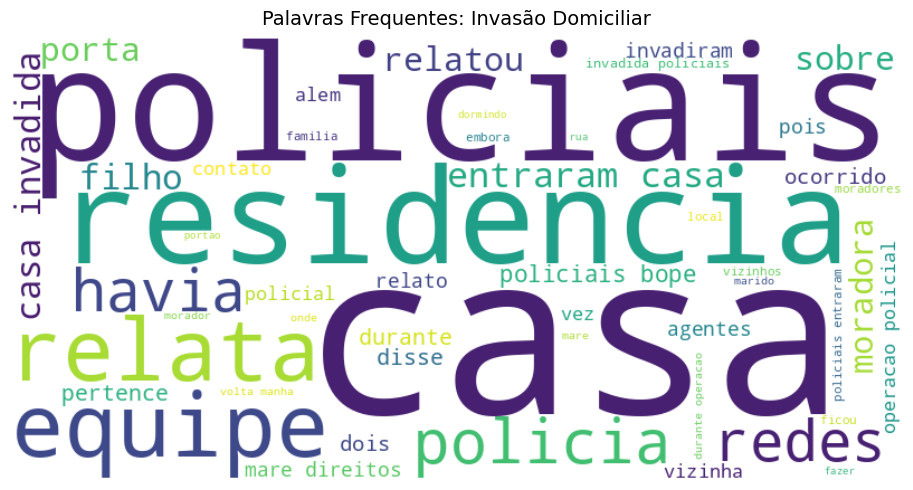


Gerando nuvem de palavras para: Violência Física


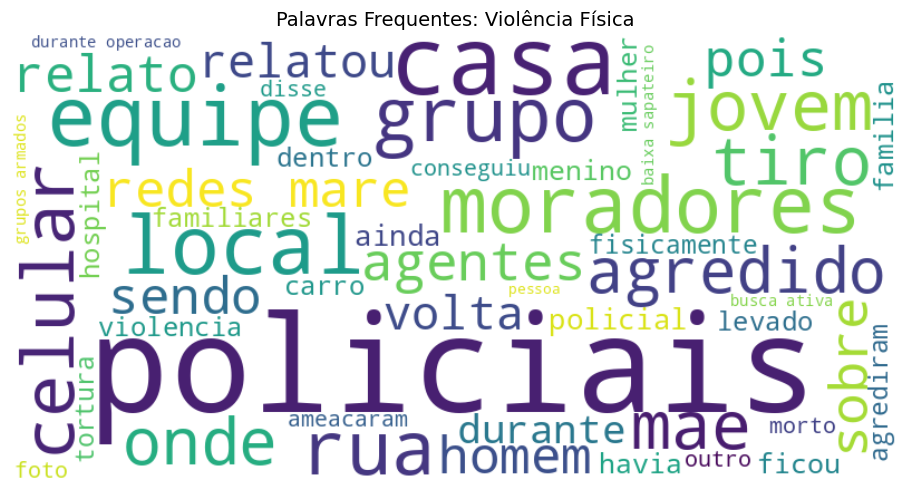

In [14]:
# Agrupar textos por classe
textos_por_classe = df.groupby('classe')['texto'].apply(lambda x: ' '.join(x.astype(str)))

# Gerar wordcloud para cada classe
for classe, texto in textos_por_classe.items():
    nome_classe = "Invasão Domiciliar" if classe == "invasao_domicilio" else "Violência Física"
    print(f"\nGerando nuvem de palavras para: {nome_classe}")
    plot_wordcloud(texto, f"Palavras Frequentes: {nome_classe}")

# **5. Palavras mais frequentes**

Análise das palavras mais frequentes separadas por classe.

In [13]:
def analisar_frequencia_palavras(texto, classe):
    texto_limpo = preprocess_text(texto)

    # Tokenização simples por espaço
    tokens = simple_tokenize(texto_limpo)

    # Filtrar stopwords e tokens muito curtos
    tokens_filtrados = [token for token in tokens if token not in stop_words and len(token) > 2]

    # Contar frequência
    freq = Counter(tokens_filtrados)

    print(f"\nTop 20 palavras mais frequentes - {classe}:")
    for palavra, count in freq.most_common(30):
        print(f"{palavra}: {count}")


# Analisar frequência para cada classe
for classe, texto in textos_por_classe.items():
    nome_classe = "Invasão Domiciliar" if classe == "invasao_domicilio" else "Violência Física"
    analisar_frequencia_palavras(texto, nome_classe)


Top 20 palavras mais frequentes - Invasão Domiciliar:
casa: 131
policiais: 76
equipe: 27
relata: 26
residencia: 25
havia: 25
invadida: 25
operacao: 24
entraram: 24
durante: 21
policial: 20
redes: 19
mare: 19
porta: 19
bope: 16
policia: 16
sobre: 15
relatou: 15
moradora: 14
volta: 13
disse: 13
manha: 12
ocorrido: 12
dois: 12
pertences: 11
invadiram: 11
pois: 11
direitos: 11
agentes: 11
filha: 10

Top 20 palavras mais frequentes - Violência Física:
policiais: 87
casa: 33
equipe: 30
moradores: 28
mare: 28
rua: 25
local: 25
grupo: 21
durante: 19
celular: 19
jovem: 18
redes: 18
mae: 17
policial: 16
onde: 16
agentes: 14
sobre: 14
agredido: 13
sendo: 13
dois: 13
pois: 13
tiros: 13
hospital: 13
homem: 13
relatou: 12
busca: 12
volta: 12
violencia: 12
jovens: 11
ainda: 11
